In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import LocallySparseNoise
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")

In [3]:
client.get_all_session_ids()

['M409828_11',
 'M409828_12',
 'M409828_13',
 'M409828_14',
 'M409828_15',
 'M409828_16',
 'M409828_17',
 'M409828_18',
 'M409828_19',
 'M409828_1a',
 'M409828_1b',
 'M409828_1c',
 'M409828_1d',
 'M409828_1e',
 'M409828_1f']

In [4]:
def rf_center_to_alt_azi(lsn, alt_ctr, azi_ctr):
    # Assumes lsn.altitudes and lsn.azimuths are equally-spaced (which is true in our case; 9.3 deg spacing)
    alt = alt_ctr * (lsn.altitudes[-1] - lsn.altitudes[0]) / len(lsn.altitudes) + lsn.altitudes[0]
    azi = azi_ctr * (lsn.azimuths[-1] - lsn.azimuths[0]) / len(lsn.azimuths) + lsn.azimuths[0]
    return alt, azi

In [6]:
FRAC_SIG_TRIALS_THRESH = 0.25 # ~11 in ~44 total

metrics_rows = []

for vol in tqdm([1, 2, 3, 4, 5, 6]):
    session = client.load_ophys_session(mouse=409828, column=1, volume=vol)

    for plane in tqdm(session.get_planes(), leave=False, desc=f"Volume {vol}"):
        lsn = LocallySparseNoise(session, plane)
        design_matrix_int = lsn.design_matrix.astype(int)
        n_pixel_trials = lsn.design_matrix.sum(axis=1) # shape (n_pixels,)
        roi_boot_95 = np.quantile(lsn.get_spont_null_dist(lsn.baseline_time_window, lsn.response_time_window, n_boot=10000, trace_type=lsn.trace_type, cache=False), 0.95, axis=1)

        for roi in session.get_rois(plane):
            metrics = {}
            metrics_rows.append(metrics)

            metrics["volume"] = vol
            metrics["roi"] = f"{session.get_session_id()}_{plane}_{roi}"
            metrics["is_valid"] = session.is_roi_valid(plane, roi)

            if not metrics["is_valid"]:
                continue

            roi_sweep_responses = lsn.sweep_responses[:, roi]
            roi_sig_sweep_responses = roi_sweep_responses > roi_boot_95[roi]
            frac_sig_trials = design_matrix_int.dot(roi_sig_sweep_responses) / n_pixel_trials
            is_pixel_sig = frac_sig_trials >= FRAC_SIG_TRIALS_THRESH
            is_responsive = np.count_nonzero(is_pixel_sig) > 0
            rf_on = np.where(is_pixel_sig, frac_sig_trials, 0)[:lsn.n_pixels].reshape(lsn.image_shape)
            rf_off = np.where(is_pixel_sig, frac_sig_trials, 0)[lsn.n_pixels:].reshape(lsn.image_shape)

            metrics["is_responsive"] = is_responsive

            for onoff, rf in (("on", rf_on), ("off", rf_off)):
                has_onoff_rf = np.count_nonzero(rf) > 0
                metrics[f"has_rf_{onoff}"] = has_onoff_rf
                
                if has_onoff_rf:
                    alt, azi = rf_center_to_alt_azi(lsn, *np.mean(np.where(rf), axis=1))
                    metrics[f"rf_{onoff}_alt_deg"] = alt
                    metrics[f"rf_{onoff}_azi_deg"] = azi
            
            # Save ROI centroid
            image_mask = session.get_roi_image_mask(plane, roi)
            y, x = np.mean(np.where(image_mask), axis=1)
            metrics["roi_centroid_x_px"] = x
            metrics["roi_centroid_y_px"] = y
            metrics["depth_microns"] = session.get_plane_depth(plane)

metrics = pd.DataFrame(metrics_rows)
metrics.set_index("roi", inplace=True)
# metrics.index.name = f"{session.get_session_id()}_{plane} ROI"
metrics["rf_on_dist_to_origin_deg"] = np.sqrt(metrics.rf_on_alt_deg**2 + metrics.rf_on_azi_deg**2)
metrics["rf_off_dist_to_origin_deg"] = np.sqrt(metrics.rf_off_alt_deg**2 + metrics.rf_off_azi_deg**2)
metrics["rf_on_off_dist_deg"] = np.sqrt((metrics.rf_on_alt_deg - metrics.rf_off_alt_deg)**2 + (metrics.rf_on_azi_deg - metrics.rf_off_azi_deg)**2)

metrics = metrics[metrics.is_valid]
print(f"Responsive rate: {metrics.is_responsive.sum()} / {len(metrics)} ({metrics.is_responsive.mean()*100:.1f}%)")

metrics

  0%|          | 0/6 [00:00<?, ?it/s]

Volume 1:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 2:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 3:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 4:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 5:   0%|          | 0/6 [00:00<?, ?it/s]

Volume 6:   0%|          | 0/1 [00:00<?, ?it/s]

Responsive rate: 1919 / 8670 (22.1%)


,volume,is_valid,is_responsive,has_rf_on,rf_on_alt_deg,rf_on_azi_deg,has_rf_off,rf_off_alt_deg,rf_off_azi_deg,roi_centroid_x_px,roi_centroid_y_px,depth_microns,rf_on_dist_to_origin_deg,rf_off_dist_to_origin_deg,rf_on_off_dist_deg
roi,,,,,,,,,,,,,,,
M409828_11_1_89,1,True,True,True,-32.550000,-25.907143,True,-12.206250,-2.158929,496.677885,257.625000,50.0,41.601473,12.395705,31.270527
M409828_11_2_0,1,True,False,False,NaN,NaN,False,NaN,NaN,91.182156,215.000000,66.0,NaN,NaN,NaN
M409828_11_2_1,1,True,False,False,NaN,NaN,False,NaN,NaN,140.030000,174.300000,66.0,NaN,NaN,NaN
M409828_11_2_2,1,True,False,False,NaN,NaN,False,NaN,NaN,182.218254,101.853175,66.0,NaN,NaN,NaN
M409828_11_2_4,1,True,True,True,-3.584375,-3.495408,True,-1.545095,-3.279385,496.240113,262.016949,66.0,5.006558,3.625146,2.050690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_16_1_178,6,True,False,False,NaN,NaN,False,NaN,NaN,295.095638,128.498322,500.0,NaN,NaN,NaN
M409828_16_1_182,6,True,False,False,NaN,NaN,False,NaN,NaN,357.235908,257.703549,500.0,NaN,NaN,NaN
M409828_16_1_185,6,True,False,False,NaN,NaN,False,NaN,NaN,31.436416,324.956647,500.0,NaN,NaN,NaN


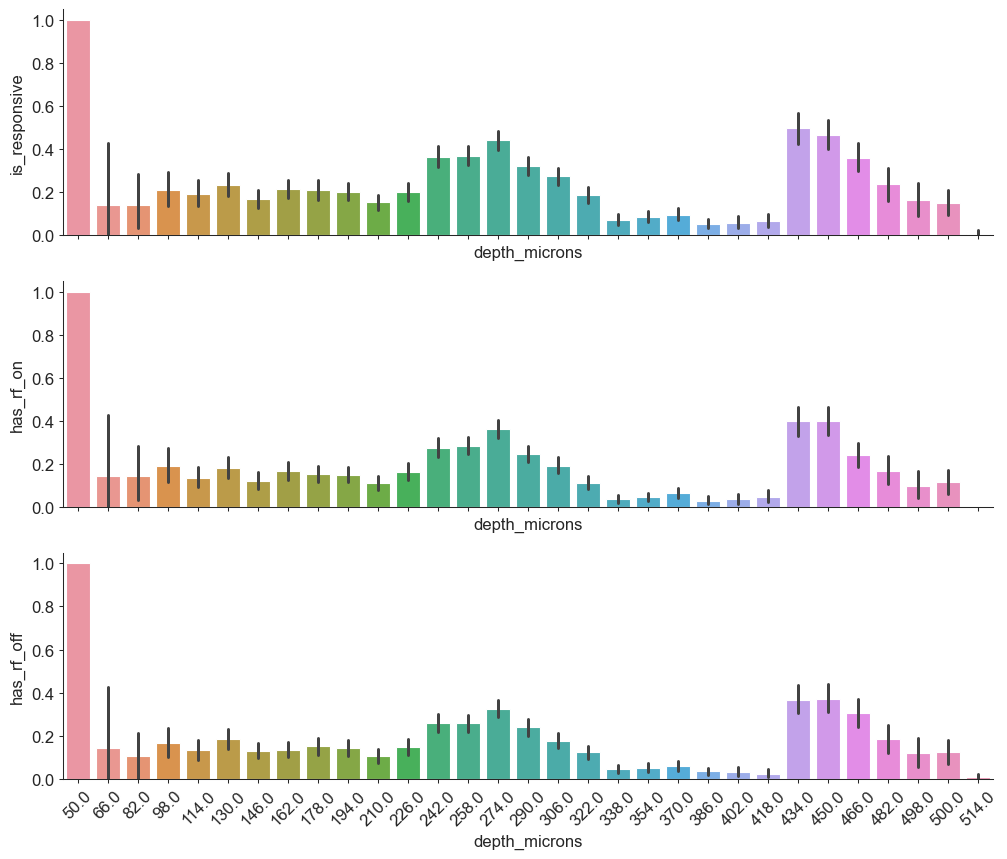

In [11]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, sharex=True)
sns.barplot(data=metrics, x="depth_microns", y="is_responsive", ax=axs[0])
sns.barplot(data=metrics, x="depth_microns", y="has_rf_on", ax=axs[1])
sns.barplot(data=metrics, x="depth_microns", y="has_rf_off", ax=axs[2])
plt.setp((ax.get_xticklabels() for ax in axs), rotation=45)
None

Volume 1: 0.1686541737649063 0.16183986371379896 0.11754684838160136
Volume 2: 0.1452081316553727 0.1355275895450145 0.08857696030977735
Volume 3: 0.24852289512555392 0.2326440177252585 0.15214180206794684
Volume 4: 0.04510599909788002 0.04420387911592242 0.014884979702300407
Volume 5: 0.25699481865284973 0.2632124352331606 0.18652849740932642
Volume 6: 0.11811023622047244 0.12598425196850394 0.09448818897637795


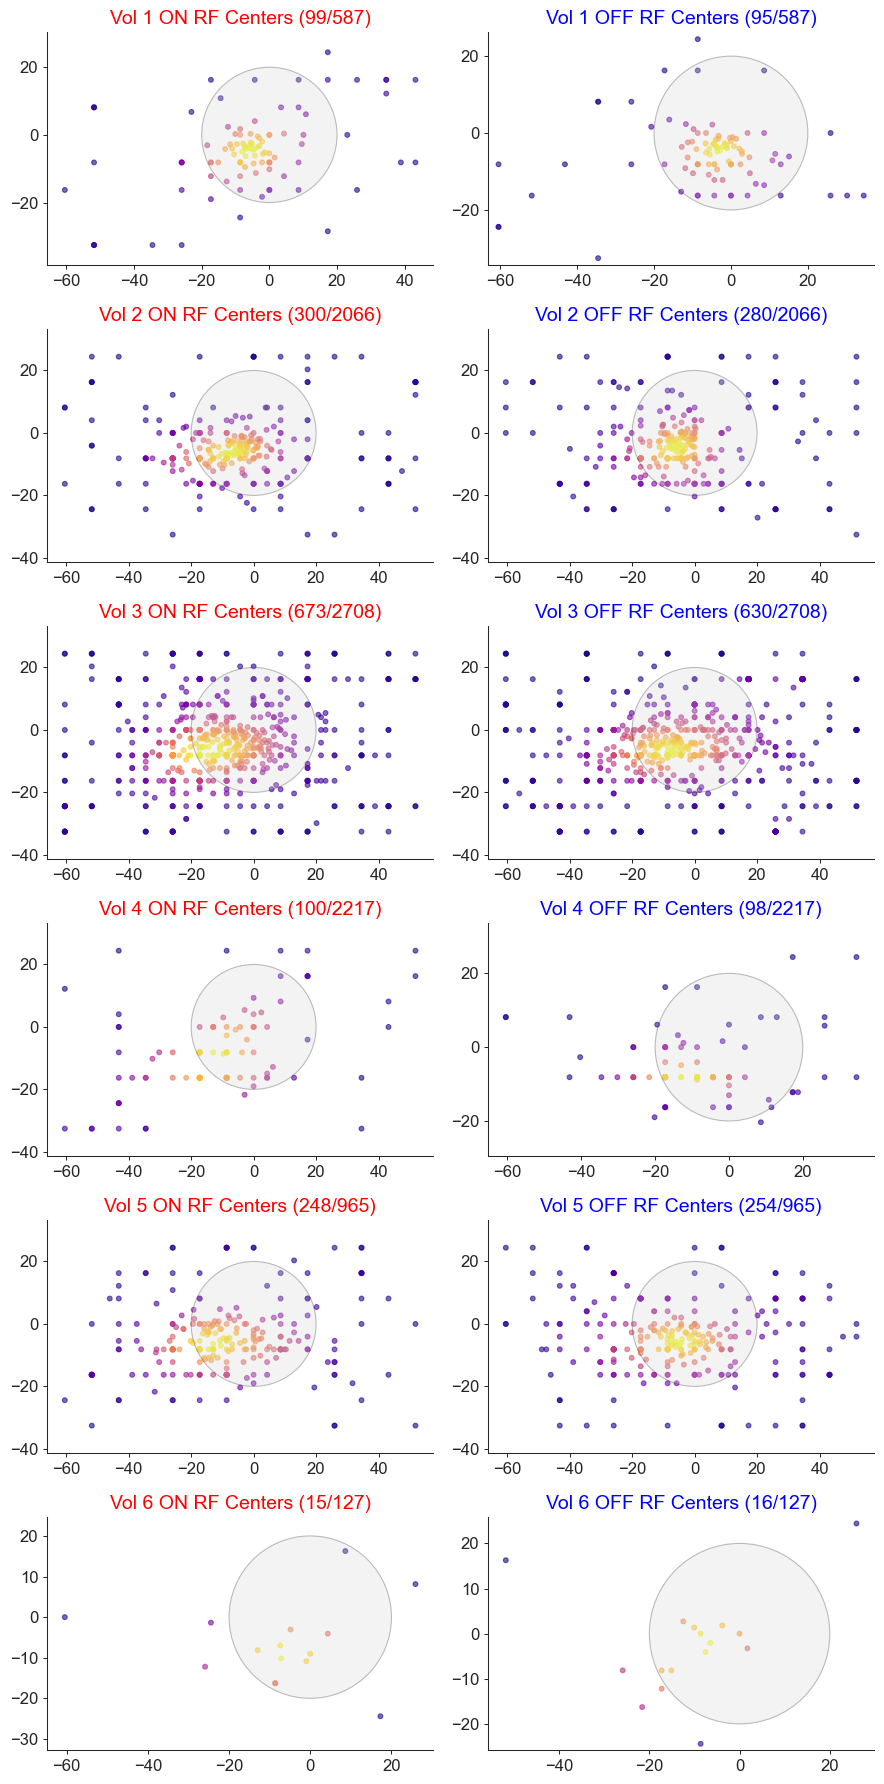

In [17]:
volumes = metrics.volume.unique()
r = 20

fig, axs = plt.subplots(figsize=(9, 3*len(volumes)), nrows=len(volumes), ncols=2)

for row_i, volume in enumerate(volumes):
    vol_met = metrics[metrics.volume == volume]

    # (vol_met.rf_on_dist_to_origin_deg[vol_met.has_rf_on] <= r).mean()*100
    axs[row_i, 0].set_title(f"Vol {volume} ON RF Centers ({vol_met.has_rf_on.sum()}/{len(vol_met)})", color="red")
    at.density_scatter(vol_met.rf_on_azi_deg[vol_met.has_rf_on], vol_met.rf_on_alt_deg[vol_met.has_rf_on], ax=axs[row_i, 0])
    axs[row_i, 0].axis("equal")

    # (vol_met.rf_on_dist_to_origin_deg[vol_met.has_rf_off] <= r).mean()*100
    axs[row_i, 1].set_title(f"Vol {volume} OFF RF Centers ({vol_met.has_rf_off.sum()}/{len(vol_met)})", color="blue")
    at.density_scatter(vol_met.rf_off_azi_deg[vol_met.has_rf_off], vol_met.rf_off_alt_deg[vol_met.has_rf_off], ax=axs[row_i, 1])
    axs[row_i, 1].axis("equal")

    print(f"Volume {volume}:", vol_met.has_rf_on.mean(), vol_met.has_rf_off.mean(), (vol_met.has_rf_on & vol_met.has_rf_off).mean())

for ax in axs.flat:
    ax.add_patch(plt.Circle((0, 0), r, edgecolor="black", facecolor="lightgray", alpha=0.25))

fig.tight_layout()


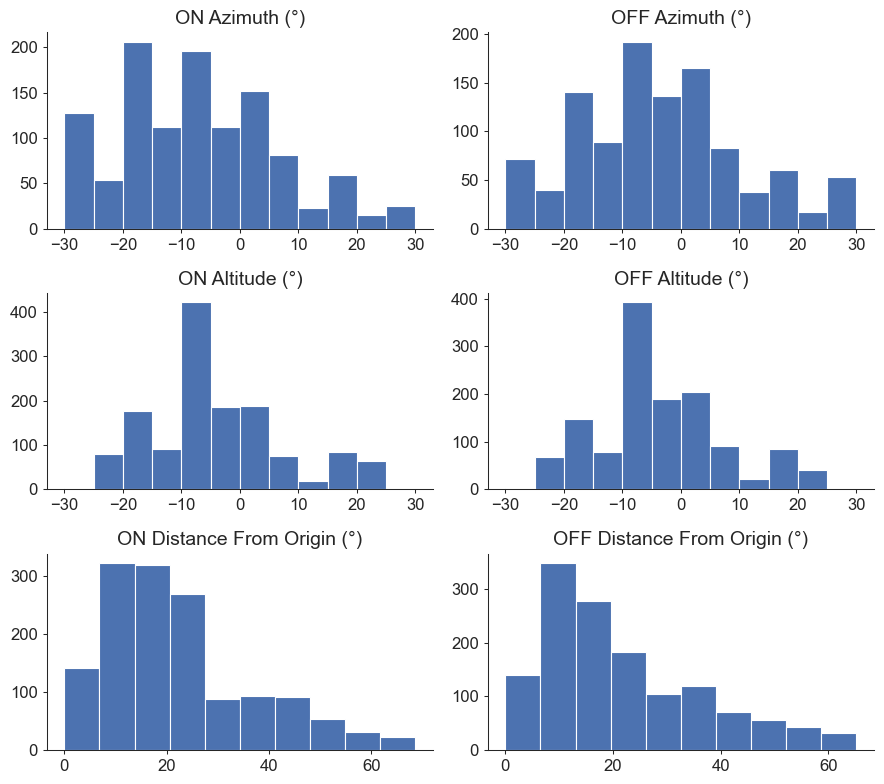

In [10]:
fig, axs = plt.subplots(figsize=(9, 8), nrows=3, ncols=2)
axs[0, 0].hist(metrics.rf_on_azi_deg[metrics.has_rf_on], bins=np.arange(-30, 35, 5))
axs[0, 0].set_title("ON Azimuth (°)")
axs[0, 1].hist(metrics.rf_off_azi_deg[metrics.has_rf_off], bins=np.arange(-30, 35, 5))
axs[0, 1].set_title("OFF Azimuth (°)")

axs[1, 0].hist(metrics.rf_on_alt_deg[metrics.has_rf_on], bins=np.arange(-30, 35, 5))
axs[1, 0].set_title("ON Altitude (°)")
axs[1, 1].hist(metrics.rf_off_alt_deg[metrics.has_rf_off], bins=np.arange(-30, 35, 5))
axs[1, 1].set_title("OFF Altitude (°)")

axs[2, 0].hist(metrics.rf_on_dist_to_origin_deg[metrics.has_rf_on])
axs[2, 0].set_title("ON Distance From Origin (°)")
axs[2, 1].hist(metrics.rf_off_dist_to_origin_deg[metrics.has_rf_off])
axs[2, 1].set_title("OFF Distance From Origin (°)")

fig.tight_layout()